In [ ]:
import sys, os, re, math
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

import matplotlib.pyplot as plt
import seaborn as sns

print("Python exe:", sys.executable)
print("Working dir:", os.getcwd())

Python exe: d:\DA_Final_Tox21\Final_DA.conda_envs\drug_discovery\python.exe
Working dir: d:\DA_Final_Tox21


In [ ]:
# Load Tox21 (DeepChem) dataset
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(
    featurizer='Raw',
    splitter=None
)

# datasets chỉ có 1 phần tử: full dataset
full_dc = datasets[0]

print("Number of tasks/endpoints:", len(tasks))
print("Tasks:", tasks)
print("Total samples:", len(full_dc))

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
d:\DA_Final_Tox21\Final_DA.conda_envs\drug_discovery\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch

Number of tasks/endpoints: 12
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Total samples: 7823


### **Convert DeepChem → DataFrame**

In [3]:
# DeepChem Dataset to dataframe
X_smiles = full_dc.ids        # SMILES
Y = full_dc.y                 # shape (N, num_tasks)
W = full_dc.w                 # mask for missing labels

df = pd.DataFrame({"smiles": X_smiles})

# add each endpoint label and mask
for j, t in enumerate(tasks):
    df[t] = Y[:, j]
    df[f"{t}_w"] = W[:, j]

print("df shape:", df.shape)
df.head()


df shape: (7823, 25)


,smiles,NR-AR,NR-AR_w,NR-AR-LBD,NR-AR-LBD_w,NR-AhR,NR-AhR_w,NR-Aromatase,NR-Aromatase_w,NR-ER,...,SR-ARE,SR-ARE_w,SR-ATAD5,SR-ATAD5_w,SR-HSE,SR-HSE_w,SR-MMP,SR-MMP_w,SR-p53,SR-p53_w
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,1.044317,0.0,1.036383,1.0,8.518229,0.0,0.000000,0.0,...,1.0,6.183652,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,1.192914,0.0,0.000000,0.0,1.061104,0.0,0.000000,0.0,0.000000
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,...,0.0,1.192914,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677


### **Kiểm tra SMILES (valid/invalid) + loại invalid**

In [4]:
def is_valid_smiles(s):
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return False
    mol = Chem.MolFromSmiles(str(s))
    return mol is not None

df["is_valid"] = df["smiles"].apply(is_valid_smiles)

print("Total:", len(df))
print("Valid:", df["is_valid"].sum())
print("Invalid:", (~df["is_valid"]).sum())

df = df[df["is_valid"]].drop(columns=["is_valid"]).reset_index(drop=True)
print("After removing invalid:", len(df))

[13:05:32] WARNING: not removing hydrogen atom without neighbors


Total: 7823
Valid: 7823
Invalid: 0
After removing invalid: 7823


### **Canonicalize SMILES + remove duplicates**

In [5]:
def canonicalize_smiles(s):
    mol = Chem.MolFromSmiles(str(s))
    return Chem.MolToSmiles(mol, canonical=True) if mol is not None else None

df["smiles_canon"] = df["smiles"].apply(canonicalize_smiles)

before = len(df)
df = df.dropna(subset=["smiles_canon"]).drop_duplicates(subset=["smiles_canon"]).reset_index(drop=True)
after = len(df)

print("Before dedup:", before)
print("After dedup :", after)

# dùng smiles_canon làm SMILES chính
df = df.drop(columns=["smiles"]).rename(columns={"smiles_canon": "smiles"})
df.head()

[13:05:34] WARNING: not removing hydrogen atom without neighbors


Before dedup: 7823
After dedup : 7823


,NR-AR,NR-AR_w,NR-AR-LBD,NR-AR-LBD_w,NR-AhR,NR-AhR_w,NR-Aromatase,NR-Aromatase_w,NR-ER,NR-ER_w,...,SR-ARE_w,SR-ATAD5,SR-ATAD5_w,SR-HSE,SR-HSE_w,SR-MMP,SR-MMP_w,SR-p53,SR-p53_w,smiles
0,0.0,1.044317,0.0,1.036383,1.0,8.518229,0.0,0.000000,0.0,0.000000,...,6.183652,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,1.192914,0.0,0.000000,0.0,1.061104,0.0,0.000000,0.0,0.000000,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,0.000000,0.0,1.038818,0.0,0.000000,0.0,1.187884,0.0,1.066677,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,1.044317,0.0,1.036383,0.0,1.133010,0.0,1.054397,0.0,1.146617,...,1.192914,0.0,1.038818,0.0,1.061104,0.0,1.187884,0.0,1.066677,CC(O)(P(=O)(O)O)P(=O)(O)O


### **EDA missing labels theo từng endpoint**

In [6]:
endpoint_stats = []
for t in tasks:
    w = df[f"{t}_w"].values
    y = df[t].values
    
    n_total = len(df)
    n_labeled = int((w > 0).sum())
    n_missing = n_total - n_labeled
    
    # positive rate trên phần có label
    if n_labeled > 0:
        pos = int(((y == 1) & (w > 0)).sum())
        neg = int(((y == 0) & (w > 0)).sum())
        pos_rate = pos / n_labeled
    else:
        pos = neg = 0
        pos_rate = np.nan
    
    endpoint_stats.append([t, n_labeled, n_missing, pos, neg, pos_rate])

# Biểu diễn thống kê các endpoint
stats_df = pd.DataFrame(endpoint_stats, columns=["endpoint", "labeled", "missing", "pos", "neg", "pos_rate"])
stats_df = stats_df.sort_values("pos_rate", ascending=False).reset_index(drop=True)
stats_df

,endpoint,labeled,missing,pos,neg,pos_rate
0,SR-ARE,5825,1998,942,4883,0.161717
1,SR-MMP,5804,2019,918,4886,0.158167
2,NR-ER,6186,1637,791,5395,0.127869
3,NR-AhR,6542,1281,768,5774,0.117395
4,SR-p53,6767,1056,423,6344,0.062509
5,SR-HSE,6460,1363,372,6088,0.057585
6,NR-Aromatase,5815,2008,300,5515,0.051591
7,NR-ER-LBD,6948,875,349,6599,0.050230
8,NR-AR,7258,565,308,6950,0.042436
9,SR-ATAD5,7065,758,264,6801,0.037367


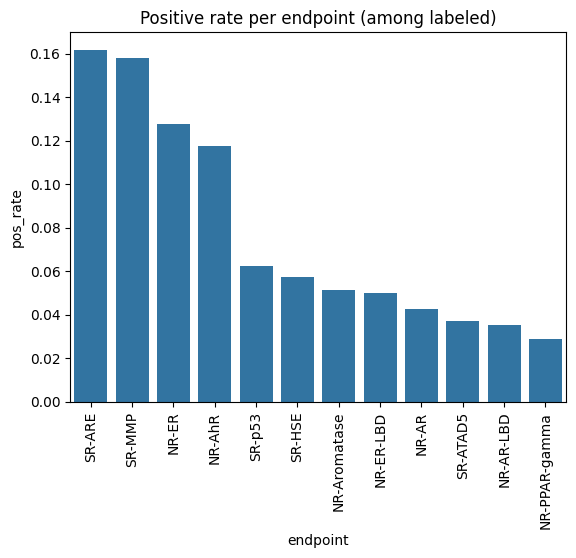

In [7]:
plt.figure()
sns.barplot(data=stats_df, x="endpoint", y="pos_rate")
plt.xticks(rotation=90)
plt.title("Positive rate per endpoint (among labeled)")
plt.show()

### **EDA Missing labels (tổng quan + theo endpoint + theo mẫu)**

In [8]:
# ---- Missing EDA (mask-based) ----
y_cols = [t for t in tasks]
w_cols = [f"{t}_w" for t in tasks]

y_mat = df[y_cols].values
w_mat = df[w_cols].values

# 1) Sanity check: w nên là 0/1 (hoặc 0/1 float)
unique_w = np.unique(w_mat)
print("Unique values in W (show up to 20):", unique_w[:20])
print("W min/max:", w_mat.min(), w_mat.max())

Unique values in W (show up to 20): [ 0.          1.02972671  1.03638317  1.03881782  1.04431655  1.0528868
  1.0543971   1.06110381  1.06667718  1.13301005  1.14661724  1.18788375
  1.19291419  6.1836518   6.32244009  7.8204804   8.51822917 15.99763593
 17.3655914  19.38333333]
W min/max: 0.0 34.63978494623656


In [9]:
# 2) Đếm số endpoint có nhãn (đúng chuẩn)
df["n_labeled_endpoints"] = (w_mat > 0).sum(axis=1).astype(int)
print(df["n_labeled_endpoints"].describe())
print("Max should be <= 12. Actual max:", df["n_labeled_endpoints"].max())

# 3) Tạo nhãn toxic theo rule đã chốt (mask-aware)
has_any_positive = ((y_mat == 1) & (w_mat > 0)).any(axis=1)
df["toxic"] = np.where(has_any_positive, 1, 0).astype(int)

print("toxic distribution:")
print(df["toxic"].value_counts())

count    7823.000000
mean        9.953215
std         2.767586
min         1.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        12.000000
Name: n_labeled_endpoints, dtype: float64
Max should be <= 12. Actual max: 12
toxic distribution:
toxic
0    4954
1    2869
Name: count, dtype: int64


In [10]:
# 4) tạo nhãn non-toxic nghiêm để lọc candidate sau này
K = 10  # bạn có thể đổi sau khi xem histogram
df["non_toxic_strict"] = ((df["toxic"] == 0) & (df["n_labeled_endpoints"] >= K)).astype(int)

print(f"non_toxic_strict with K={K}:")
print(df["non_toxic_strict"].value_counts())

non_toxic_strict with K=10:
non_toxic_strict
1    4016
0    3807
Name: count, dtype: int64


In [ ]:
# for K in [6, 8, 10, 12]:
#     non_toxic_strict = ((df["toxic"] == 0) & (df["n_labeled_endpoints"] >= K)).mean()
#     keep_rate = (df["n_labeled_endpoints"] >= K).mean()
#     print(f"K={K:>2} | keep_rate={keep_rate:.3f} | strict_non_toxic_rate={non_toxic_strict:.3f}")

K= 6 | keep_rate=0.912 | strict_non_toxic_rate=0.577
K= 8 | keep_rate=0.856 | strict_non_toxic_rate=0.564
K=10 | keep_rate=0.724 | strict_non_toxic_rate=0.513
K=12 | keep_rate=0.393 | strict_non_toxic_rate=0.307


K=10:
* Giữ 72.4% molecule
* Non-toxic_rate ≈ 51%
* -> Cân bằng tốt giữa độ tin cậy & coverage

### **Tạo Murcko scaffold**

In [12]:
# ---- Scaffold analysis ----
from rdkit.Chem.Scaffolds import MurckoScaffold

# Hàm lấy Murcko scaffold từ SMILES
def murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaf = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaf, canonical=True) if scaf is not None else None

df["scaffold"] = df["smiles"].apply(murcko_scaffold) 

# Thống kê scaffold
print("Total molecules:", len(df))
print("Missing scaffold:", df["scaffold"].isna().sum())
print("Unique scaffolds:", df["scaffold"].nunique())


[13:12:31] WARNING: not removing hydrogen atom without neighbors


Total molecules: 7823
Missing scaffold: 0
Unique scaffolds: 2404


In [13]:
# Scaffold split 80 / 10 / 10
from collections import defaultdict

# group indices by scaffold
scaffold_to_indices = defaultdict(list)
for idx, scaf in enumerate(df["scaffold"]):
    scaffold_to_indices[scaf].append(idx)

# sort scaffolds by size (desc) để phân bổ ổn định
scaffolds = sorted(
    scaffold_to_indices.keys(),
    key=lambda s: len(scaffold_to_indices[s]),
    reverse=True
)

n_total = len(df)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

train_idx, val_idx, test_idx = [], [], []

for scaf in scaffolds:
    idxs = scaffold_to_indices[scaf]
    if len(train_idx) + len(idxs) <= n_train:
        train_idx.extend(idxs)
    elif len(val_idx) + len(idxs) <= n_val:
        val_idx.extend(idxs)
    else:
        test_idx.extend(idxs)

print("Split sizes:")
print("Train:", len(train_idx))
print("Val  :", len(val_idx))
print("Test :", len(test_idx))
print("Total:", len(train_idx) + len(val_idx) + len(test_idx))

Split sizes:
Train: 6258
Val  : 782
Test : 783
Total: 7823


### **Kiểm tra scaffold không bị leak + imbalance theo split**

In [14]:
train_df = df.iloc[train_idx].copy()
val_df   = df.iloc[val_idx].copy()
test_df  = df.iloc[test_idx].copy()

# verify scaffold disjointness
print("Train ∩ Val:", len(set(train_df["scaffold"]) & set(val_df["scaffold"])))
print("Train ∩ Test:", len(set(train_df["scaffold"]) & set(test_df["scaffold"])))
print("Val ∩ Test:", len(set(val_df["scaffold"]) & set(test_df["scaffold"])))

def split_stats(name, d):
    c = d["toxic"].value_counts()
    total = len(d)
    pos = int(c.get(1, 0))
    return {
        "split": name,
        "n": total,
        "toxic_pos": pos,
        "toxic_rate": pos / total
    }

pd.DataFrame([
    split_stats("train", train_df),
    split_stats("val", val_df),
    split_stats("test", test_df),
])

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


,split,n,toxic_pos,toxic_rate
0,train,6258,2174,0.347395
1,val,782,347,0.443734
2,test,783,348,0.444444


In [15]:
# Save processed datasets
os.makedirs("data/processed", exist_ok=True)

cols_to_save = ["smiles", "toxic", "non_toxic_strict", "n_labeled_endpoints", "scaffold"]

train_df[cols_to_save].to_csv("data/processed/tox21_train.csv", index=False)
val_df[cols_to_save].to_csv("data/processed/tox21_val.csv", index=False)
test_df[cols_to_save].to_csv("data/processed/tox21_test.csv", index=False)

print("Saved processed datasets to data/processed/")

Saved processed datasets to data/processed/


### **Tạo Morgan Fingerprints (train / val / test)**

In [ ]:
# ---- Generate Morgan fingerprints ----
def morgan_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return np.array(
        AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits),
        dtype=np.int8
    )

# tạo fingerprint matrix
X_train = np.stack(train_df["smiles"].apply(morgan_fp))
X_val   = np.stack(val_df["smiles"].apply(morgan_fp))
X_test  = np.stack(test_df["smiles"].apply(morgan_fp))

y_train = train_df["toxic"].values
y_val   = val_df["toxic"].values
y_test  = test_df["toxic"].values

[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerator
[13:19:24] DEPRECATION WARNING: please use MorganGenerat

Shapes:
X_train: (6258, 2048) y_train: (6258,)
X_val  : (782, 2048) y_val  : (782,)
X_test : (783, 2048) y_test : (783,)


[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerator
[13:19:36] DEPRECATION WARNING: please use MorganGenerat

In [17]:
print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

Shapes:
X_train: (6258, 2048) y_train: (6258,)
X_val  : (782, 2048) y_val  : (782,)
X_test : (783, 2048) y_test : (783,)


### **Train Baseline Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Đánh giá Baseline (AUPRC + F1, threshold tuning)
# Metric functions
from sklearn.metrics import average_precision_score, f1_score, precision_recall_curve

def evaluate_pr(y_true, y_score, threshold=0.5):
    y_pred = (y_score >= threshold).astype(int)
    auprc = average_precision_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    return auprc, f1

In [21]:
# Tìm threshold tối ưu F1 trên validation set
# predict probabilities
val_probs = rf.predict_proba(X_val)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_val, val_probs)

f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
val_auprc = average_precision_score(y_val, val_probs)

print("Best threshold (val):", best_threshold)
print("Val AUPRC:", val_auprc)
print("Val F1 (best):", best_f1)

Best threshold (val): 0.30550868222009164
Val AUPRC: 0.6660778027576435
Val F1 (best): 0.6629213435571014


In [22]:
# Đánh giá trên test set với threshold đã chọn
test_probs = rf.predict_proba(X_test)[:, 1]

test_auprc, test_f1 = evaluate_pr(
    y_test,
    test_probs,
    threshold=best_threshold
)

print("Test AUPRC:", test_auprc)
print("Test F1:", test_f1)

Test AUPRC: 0.6456295361599518
Test F1: 0.6473317865429234


In [24]:
# save baselien model
baseline_results = {
    "model": "RandomForest",
    "val_auprc": val_auprc,
    "val_f1": best_f1,
    "test_auprc": test_auprc,
    "test_f1": test_f1,
    "threshold": float(best_threshold)
}

baseline_results

{'model': 'RandomForest',
 'val_auprc': 0.6660778027576435,
 'val_f1': np.float64(0.6629213435571014),
 'test_auprc': 0.6456295361599518,
 'test_f1': 0.6473317865429234,
 'threshold': 0.30550868222009164}

### **ADVANCED MODEL – Dense Neural Network (MLP)**

Advanced model = Dense NN trên Morgan fingerprints
* Early stopping
* Validation-based threshold tuning
* So sánh với baseline

#### **TensorDataset + DataLoader**

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [26]:
# convert numpy -> torch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### **Định nghĩa Dense Neural Network (Advanced Architecture)**

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class ToxicityMLP(nn.Module):
    def __init__(self, input_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = ToxicityMLP().to(device)
model

ToxicityMLP(
  (net): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### **Loss, optimizer, class weighting**
* BCEWithLogitsLoss + class imbalance handling.

In [28]:
from sklearn.utils.class_weight import compute_class_weight

# compute class weights from training set
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# Training loop với Early Stopping (theo Val AUPRC)
from sklearn.metrics import average_precision_score

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    return total_loss / len(loader.dataset)

def eval_auc(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.append(y.numpy())
            ps.append(probs)
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    return average_precision_score(y_true, y_prob), y_true, y_prob

best_val_auprc = 0.0
patience = 10
counter = 0

for epoch in range(1, 101):
    train_loss = train_one_epoch(model, train_loader)
    val_auprc, _, _ = eval_auc(model, val_loader)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_AUPRC={val_auprc:.4f}")

    if val_auprc > best_val_auprc:
        best_val_auprc = val_auprc
        best_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(best_state)

Epoch 001 | train_loss=0.8131 | val_AUPRC=0.6479
Epoch 002 | train_loss=0.5653 | val_AUPRC=0.6088
Epoch 003 | train_loss=0.4326 | val_AUPRC=0.6007
Epoch 004 | train_loss=0.3251 | val_AUPRC=0.6073
Epoch 005 | train_loss=0.2726 | val_AUPRC=0.6122
Epoch 006 | train_loss=0.2125 | val_AUPRC=0.6458
Epoch 007 | train_loss=0.1867 | val_AUPRC=0.6215
Epoch 008 | train_loss=0.1608 | val_AUPRC=0.6359
Epoch 009 | train_loss=0.1472 | val_AUPRC=0.6034
Epoch 010 | train_loss=0.1309 | val_AUPRC=0.6117
Epoch 011 | train_loss=0.1155 | val_AUPRC=0.6055
Early stopping triggered


<All keys matched successfully>

#### **Threshold tuning + Test evaluation**

In [30]:
from sklearn.metrics import precision_recall_curve, f1_score

# validation probs
_, y_val_true, y_val_prob = eval_auc(model, val_loader)

prec, rec, thresholds = precision_recall_curve(y_val_true, y_val_prob)
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold_nn = thresholds[best_idx]

print("Best threshold (val):", best_threshold_nn)
print("Best val F1:", f1_scores[best_idx])

# test evaluation
test_auprc, y_test_true, y_test_prob = eval_auc(model, test_loader)
test_pred = (y_test_prob >= best_threshold_nn).astype(int)
test_f1 = f1_score(y_test_true, test_pred)

print("Test AUPRC:", test_auprc)
print("Test F1:", test_f1)

Best threshold (val): 7.485115e-05
Best val F1: 0.6229508150895467
Test AUPRC: 0.5960133824243911
Test F1: 0.6059979317476732


In [31]:
# Save NN advanced model
advanced_results = {
    "model": "DenseNN",
    "val_auprc": best_val_auprc,
    "val_f1": float(f1_scores[best_idx]),
    "test_auprc": test_auprc,
    "test_f1": test_f1,
    "threshold": float(best_threshold_nn)
}

advanced_results

{'model': 'DenseNN',
 'val_auprc': 0.6479470138958078,
 'val_f1': 0.6229508150895467,
 'test_auprc': 0.5960133824243911,
 'test_f1': 0.6059979317476732,
 'threshold': 7.485115202143788e-05}

#### **Baseline RandomForest**
* Test AUPRC: 0.6456
* Test F1: 0.6473
* Threshold: 0.3055

#### **Dense NN**
* Test AUPRC: 0.5960
* Test F1: 0.6060
* Threshold: 7.5e-05 (tệ)

>-> Chỉnh lại Dense NN
* Sửa pos_weight
* Thêm L2 (weight decay)
* Giảm learning rate
* Dùng scheduler nhẹ
* Giữ early stopping theo val AUPRC

In [32]:
# pos_weight đúng cho BCEWithLogitsLoss = n_negative / n_positive
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

print("n_pos:", n_pos, "n_neg:", n_neg)
print("pos_weight:", pos_weight.item())

n_pos: 2174 n_neg: 4084
pos_weight: 1.8785648345947266


In [33]:
# Model + Optimizer tốt hơn cho tabular fingerprints

class ToxicityMLP(nn.Module):
    def __init__(self, input_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = ToxicityMLP().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-3
)


In [34]:
# Train lại (Early stopping theo val AUPRC)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    return total_loss / len(loader.dataset)

def get_probs(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.append(y.numpy())
            ps.append(probs)
    return np.concatenate(ys), np.concatenate(ps)

best_val_auprc = 0.0
best_state = None
patience = 12
counter = 0

for epoch in range(1, 101):
    train_loss = train_one_epoch(model, train_loader)

    yv, pv = get_probs(model, val_loader)
    val_auprc = average_precision_score(yv, pv)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_AUPRC={val_auprc:.4f}")

    if val_auprc > best_val_auprc + 1e-4:
        best_val_auprc = val_auprc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# load best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print("Best val AUPRC:", best_val_auprc)


Epoch 001 | train_loss=0.8596 | val_AUPRC=0.6560
Epoch 002 | train_loss=0.7074 | val_AUPRC=0.6325
Epoch 003 | train_loss=0.5887 | val_AUPRC=0.6237
Epoch 004 | train_loss=0.4764 | val_AUPRC=0.5827
Epoch 005 | train_loss=0.3670 | val_AUPRC=0.6117
Epoch 006 | train_loss=0.2742 | val_AUPRC=0.6132
Epoch 007 | train_loss=0.2015 | val_AUPRC=0.6017
Epoch 008 | train_loss=0.1558 | val_AUPRC=0.6193
Epoch 009 | train_loss=0.1326 | val_AUPRC=0.5898
Epoch 010 | train_loss=0.1087 | val_AUPRC=0.6105
Epoch 011 | train_loss=0.0915 | val_AUPRC=0.5948
Epoch 012 | train_loss=0.0796 | val_AUPRC=0.6053
Epoch 013 | train_loss=0.0827 | val_AUPRC=0.5965
Early stopping triggered
Best val AUPRC: 0.6560392162395299


In [35]:
# Threshold tuning + test eval
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score

# val
yv, pv = get_probs(model, val_loader)
prec, rec, thresholds = precision_recall_curve(yv, pv)
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold (val):", best_threshold)
print("Best val F1:", f1_scores[best_idx])
print("Val AUPRC:", average_precision_score(yv, pv))

# test
yt, pt = get_probs(model, test_loader)
test_auprc = average_precision_score(yt, pt)
test_pred = (pt >= best_threshold).astype(int)
test_f1 = f1_score(yt, test_pred)

print("Test AUPRC:", test_auprc)
print("Test F1:", test_f1)

Best threshold (val): 0.4390506
Best val F1: 0.6434195677939977
Val AUPRC: 0.6560392162395299
Test AUPRC: 0.6410169126647558
Test F1: 0.6335963923337091


>### **Reference Model (ChemBERTa)**

In [36]:
# load data split
train_path = "data/processed/tox21_train.csv"
val_path   = "data/processed/tox21_val.csv"
test_path  = "data/processed/tox21_test.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

print(train_df.shape, val_df.shape, test_df.shape)
train_df.head()

(6258, 5) (782, 5) (783, 5)


,smiles,toxic,non_toxic_strict,n_labeled_endpoints,scaffold
0,CC(O)(P(=O)(O)O)P(=O)(O)O,0,1,12,NaN
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0,1,11,NaN
2,OC[C@@H](O)[C@H](O)[C@@H](O)CO,0,1,11,NaN
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],0,0,2,NaN
4,CC(C)COC(=O)C(C)C,0,1,12,NaN


In [37]:
# Kiểm tra label + class distribution
def describe_split(name, df):
    c = df["toxic"].value_counts()
    total = len(df)
    pos = int(c.get(1, 0))
    neg = int(c.get(0, 0))
    print(f"{name}: n={total}, pos={pos} ({pos/total:.3f}), neg={neg} ({neg/total:.3f})")

describe_split("train", train_df)
describe_split("val", val_df)
describe_split("test", test_df)

train: n=6258, pos=2174 (0.347), neg=4084 (0.653)
val: n=782, pos=347 (0.444), neg=435 (0.556)
test: n=783, pos=348 (0.444), neg=435 (0.556)


#### **Tokenizer + Model (ChemBERTa)**

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "seyonec/ChemBERTa-zinc-base-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Binary classification: 2 labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Device:", device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cpu


### **Tokenize SMILES (Dataset)**

In [39]:
from torch.utils.data import Dataset, DataLoader

class SmilesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.smiles = df["smiles"].astype(str).tolist()
        self.labels = df["toxic"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        s = self.smiles[idx]
        enc = self.tokenizer(
            s,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

max_len = 128  # SMILES thường đủ
train_ds = SmilesDataset(train_df, tokenizer, max_len=max_len)
val_ds   = SmilesDataset(val_df, tokenizer, max_len=max_len)
test_ds  = SmilesDataset(test_df, tokenizer, max_len=max_len)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)

(6258, 782, 783)

In [40]:
# Loss có class weight (để xử lý imbalance)

y_train = train_df["toxic"].values
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

# CrossEntropyLoss expects weight per class: [w0, w1]
# thường set w1 lớn hơn nếu positive hiếm
w0 = 1.0
w1 = n_neg / max(n_pos, 1)

class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("n_pos:", n_pos, "n_neg:", n_neg)
print("class_weights:", class_weights)

n_pos: 2174 n_neg: 4084
class_weights: tensor([1.0000, 1.8786])


### **Optimizer + training loop + Early stopping theo Val AUPRC**

In [41]:
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import average_precision_score

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 5
total_steps = num_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

def run_eval(model, loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].numpy()
            batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # P(toxic=1)
            all_labels.append(labels)
            all_probs.append(probs)
    y_true = np.concatenate(all_labels)
    y_prob = np.concatenate(all_probs)
    auprc = average_precision_score(y_true, y_prob)
    return auprc, y_true, y_prob

best_val_auprc = 0.0
best_state = None
patience = 2
counter = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        labels = batch["labels"].to(device)
        batch_inp = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        optimizer.zero_grad()
        outputs = model(**batch_inp)
        loss = criterion(outputs.logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    val_auprc, _, _ = run_eval(model, val_loader)

    print(f"Epoch {epoch} | train_loss={avg_loss:.4f} | val_AUPRC={val_auprc:.4f}")

    if val_auprc > best_val_auprc + 1e-4:
        best_val_auprc = val_auprc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# load best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print("Best val AUPRC:", best_val_auprc)

Epoch 1 | train_loss=0.6423 | val_AUPRC=0.6665
Epoch 2 | train_loss=0.5691 | val_AUPRC=0.6772
Epoch 3 | train_loss=0.5032 | val_AUPRC=0.6813
Epoch 4 | train_loss=0.4540 | val_AUPRC=0.6724
Epoch 5 | train_loss=0.4078 | val_AUPRC=0.6711
Early stopping triggered
Best val AUPRC: 0.6813065917019119


#### **Threshold tuning trên val + test evaluation (AUPRC + F1)**

In [42]:
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score

val_auprc, yv, pv = run_eval(model, val_loader)
prec, rec, thr = precision_recall_curve(yv, pv)

f1 = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = np.argmax(f1)

best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

print("Val AUPRC:", val_auprc)
print("Best val F1:", f1[best_idx])
print("Best threshold (val):", best_thr)

test_auprc, yt, pt = run_eval(model, test_loader)
test_pred = (pt >= best_thr).astype(int)
test_f1 = f1_score(yt, test_pred)

print("Test AUPRC:", test_auprc)
print("Test F1:", test_f1)

Val AUPRC: 0.6813065917019119
Best val F1: 0.6683291721480279
Best threshold (val): 0.4818883
Test AUPRC: 0.6841254134054374
Test F1: 0.6556543837357052


In [43]:
# Gói kết quả reference model (để so sánh 3 model)
reference_results = {
    "model": "ChemBERTa (reference)",
    "val_auprc": float(val_auprc),
    "val_f1": float(f1[best_idx]),
    "test_auprc": float(test_auprc),
    "test_f1": float(test_f1),
    "threshold": float(best_thr),
    "max_len": int(max_len),
    "batch_train": int(train_loader.batch_size),
}
reference_results


{'model': 'ChemBERTa (reference)',
 'val_auprc': 0.6813065917019119,
 'val_f1': 0.6683291721480279,
 'test_auprc': 0.6841254134054374,
 'test_f1': 0.6556543837357052,
 'threshold': 0.4818882942199707,
 'max_len': 128,
 'batch_train': 16}

>### **ChemBERTa là model tốt nhất trên cả Val và Test (AUPRC & F1).**
* Chốt dùng ChemBERTa
    * Chốt dùng ChemBERTa
    * Threshold = 0.482 (tối ưu theo Val F1)

#### **Lưu model ChemBERTa + lưu threshold + metadata**

In [44]:
import os, json
from datetime import datetime

SAVE_DIR = "artifacts/admet_chemberta_tox21"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) save HF model + tokenizer
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# 2) save threshold + metadata
meta = {
    "task": "ADMET_Toxicity_binary",
    "dataset": "Tox21 (MoleculeNet)",
    "split": "Scaffold split 80/10/10",
    "metrics": {
        "val_auprc": reference_results["val_auprc"],
        "val_f1": reference_results["val_f1"],
        "test_auprc": reference_results["test_auprc"],
        "test_f1": reference_results["test_f1"],
    },
    "threshold_val_opt_f1": reference_results["threshold"],
    "max_len": reference_results["max_len"],
    "batch_train": reference_results["batch_train"],
    "model_name": "seyonec/ChemBERTa-zinc-base-v1",
    "saved_at": datetime.now().isoformat()
}

with open(os.path.join(SAVE_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved to:", SAVE_DIR)
print("Threshold:", meta["threshold_val_opt_f1"])

Saved to: artifacts/admet_chemberta_tox21
Threshold: 0.4818882942199707
